<a href="https://colab.research.google.com/github/akshitt/GAN/blob/main/DCGAN_CelebA_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [ ]:
#Using GPU
print(sys.version)
device = 'cuda'
#Checking for GPU
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.is_available())

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
10.1
1
True


In [ ]:
dataroot = 'drive/My Drive/Colab Notebooks/GANs/celeba'
image_size = 64
dataset = dset.ImageFolder(root = dataroot, 
                           transform = transforms.Compose([transforms.Resize(image_size), 
                                                                            transforms.CenterCrop(image_size), 
                                                                            transforms.ToTensor(), 
                                                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

batch = 128
data_loader = DataLoader(dataset, batch_size=batch, shuffle =True, num_workers = 2)
num_batches = len(data_loader)
print(num_batches)

23


torch.Size([128, 3, 64, 64])


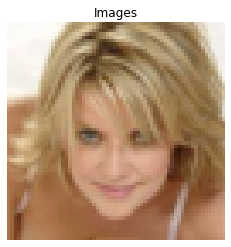

In [ ]:
#display some images 
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  #plt.imshow(np.transpose(img, (1, 2, 0)))
  #print(img.shape)
  npimg = img.cpu().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis('off')
  plt.title('Images')
  plt.show()

dataiter = iter(data_loader)
images = dataiter.next()

print(images[0].shape)
imshow(torchvision.utils.make_grid(images[0][:1], padding = 2, normalize=True))
#print(' '.join('%10s' % [labels[i]] for i in range(4)))

In [ ]:
def weights_init(m):
  classmate = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm' != -1):
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [ ]:
class DiscriminatorNet(torch.nn.Module):
  def __init__(self):
    super(DiscriminatorNet, self).__init__()
    self.main = nn.Sequential(
      nn.Conv2d(3, 128, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(128, 256, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(256, 512, kernel_size = 5, stride = 2, padding =2, bias = False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(512, 1024, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.BatchNorm2d(1024),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(1024, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
      nn.Sigmoid()
    )
    
  def forward(self, x):
    x = self.main(x)
    return x

discriminator = DiscriminatorNet().to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
print(discriminator)

DiscriminatorNet(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
def images_to_vectors(images):
  return images.view(images.size(0), 4096)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 3, 64, 64)

In [ ]:
class GeneratorNet(torch.nn.Module):
  def __init__(self):
    super(GeneratorNet, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(100, 1024, kernel_size = 4, stride = 1, padding = 0, bias = False),
        #nn.BatchNorm2d(1024),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(1024, 512, kernel_size = 4, stride = 2, padding = 1, bias =False),
        #nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
        #nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias=False),
        #nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(128, 3, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.Tanh()
    )
    

  def forward(self, x):
    #print(x)
    x = self.main(x)
    #print(x.shape)
    return x

generator = GeneratorNet().to(device)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

loss = nn.BCELoss()

print(generator)
print(loss)

GeneratorNet(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Tanh()
  )
)
BCELoss()


In [ ]:
def noise(size):
  n = Variable(torch.randn(size, 100, 1, 1))
  return n.to(device)

In [ ]:
def ones_target(size):
  data = Variable(torch.ones(size, 1))
  return data.to(device)

def zeros_target(size):
  data = Variable(torch.zeros(size, 1))
  return data.to(device)

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
  N = real_data.size(0)
  optimizer.zero_grad()

  prediction_real = discriminator(vectors_to_images(real_data)).to(device)
  loss_real = loss(prediction_real.reshape(-1, 1), ones_target(N))
  loss_real.backward()

  prediction_fake = discriminator(vectors_to_images(fake_data)).to(device)
  loss_fake = loss(prediction_fake.reshape(-1, 1), zeros_target(N))
  loss_fake.backward()

  optimizer.step()

  return loss_real+loss_fake, prediction_real, prediction_fake

In [ ]:
def train_generator(optimizer, fake_data):
  N = fake_data.size(0)
  optimizer.zero_grad()

  prediction_fake = discriminator(vectors_to_images(fake_data)).to(device)
  loss_gen = loss(prediction_fake.reshape(-1, 1), ones_target(N))
  loss_gen.backward()

  optimizer.step()

  return loss_gen

In [ ]:
num_test_samples = 4
test_noise = noise(num_test_samples)

In [ ]:
def fit(num_epochs = 450):
  G_losses = []
  D_losses = []
  for epoch in range(num_epochs):
    d_loss = 0
    g_loss = 0
    for num_iter, (real_batch, _) in enumerate(data_loader):
      #print(real_batch.size(0))
      N = real_batch.size(0)
      #print(noise(N))

      real_data = Variable(real_batch).to(device)
      fake_data = generator(noise(N)).to(device)
      d_loss_now, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data.detach())
      d_loss += d_loss_now

      fake_data = generator(noise(N)).to(device)
      g_loss_now = train_generator(g_optimizer, fake_data)
      g_loss += g_loss_now

    D_losses.append(d_loss)
    G_losses.append(g_loss)
    print("Epoch no - " + str(epoch+1))
    print("Discriminator Loss : %f \t Generator_loss : %f" % (d_loss.item(), g_loss.item()))
    print("Accuracy on Real Data : %f \t Accuracy on fake Data : %f" % (d_pred_real.mean().item(), d_pred_fake.mean().item()))

    if((epoch+1)%10 ==0):
      with torch.no_grad():
        generated_data = generator(test_noise.detach())
        imshow(torchvision.utils.make_grid(vectors_to_images(generated_data)))

  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training")
  plt.plot(G_losses,label="G")
  plt.plot(D_losses,label="D")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
    


Epoch no - 1
Discriminator Loss : 30.080690 	 Generator_loss : 307.130463
Accuracy on Real Data : 0.816366 	 Accuracy on fake Data : 0.009147
Epoch no - 2
Discriminator Loss : 10.631178 	 Generator_loss : 148.991562
Accuracy on Real Data : 0.936649 	 Accuracy on fake Data : 0.071368
Epoch no - 3
Discriminator Loss : 4.972502 	 Generator_loss : 151.156082
Accuracy on Real Data : 0.989316 	 Accuracy on fake Data : 0.023530
Epoch no - 4
Discriminator Loss : 7.008003 	 Generator_loss : 110.843674
Accuracy on Real Data : 0.868279 	 Accuracy on fake Data : 0.031821
Epoch no - 5
Discriminator Loss : 15.969750 	 Generator_loss : 104.245018
Accuracy on Real Data : 0.915743 	 Accuracy on fake Data : 0.270691
Epoch no - 6
Discriminator Loss : 24.821686 	 Generator_loss : 69.452438
Accuracy on Real Data : 0.761800 	 Accuracy on fake Data : 0.062284
Epoch no - 7
Discriminator Loss : 16.302732 	 Generator_loss : 74.817375
Accuracy on Real Data : 0.326303 	 Accuracy on fake Data : 0.008813
Epoch no -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 10
Discriminator Loss : 18.424866 	 Generator_loss : 71.285118
Accuracy on Real Data : 0.904251 	 Accuracy on fake Data : 0.365596


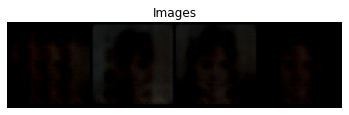

Epoch no - 11
Discriminator Loss : 17.280302 	 Generator_loss : 73.422195
Accuracy on Real Data : 0.851430 	 Accuracy on fake Data : 0.128049
Epoch no - 12
Discriminator Loss : 17.868706 	 Generator_loss : 71.122467
Accuracy on Real Data : 0.949779 	 Accuracy on fake Data : 0.240691
Epoch no - 13
Discriminator Loss : 13.712510 	 Generator_loss : 82.860664
Accuracy on Real Data : 0.521878 	 Accuracy on fake Data : 0.053137
Epoch no - 14
Discriminator Loss : 17.679356 	 Generator_loss : 85.757065
Accuracy on Real Data : 0.865114 	 Accuracy on fake Data : 0.180524
Epoch no - 15
Discriminator Loss : 9.130784 	 Generator_loss : 91.358360
Accuracy on Real Data : 0.952820 	 Accuracy on fake Data : 0.179348
Epoch no - 16
Discriminator Loss : 13.718582 	 Generator_loss : 89.618439
Accuracy on Real Data : 0.883079 	 Accuracy on fake Data : 0.325362
Epoch no - 17
Discriminator Loss : 13.846478 	 Generator_loss : 95.762962
Accuracy on Real Data : 0.947178 	 Accuracy on fake Data : 0.321519
Epoch n

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 20
Discriminator Loss : 14.599340 	 Generator_loss : 85.450317
Accuracy on Real Data : 0.590320 	 Accuracy on fake Data : 0.114373


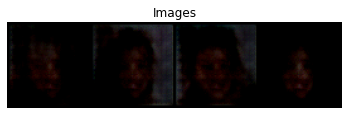

Epoch no - 21
Discriminator Loss : 12.016537 	 Generator_loss : 87.379173
Accuracy on Real Data : 0.884556 	 Accuracy on fake Data : 0.208928
Epoch no - 22
Discriminator Loss : 10.622211 	 Generator_loss : 93.597923
Accuracy on Real Data : 0.845787 	 Accuracy on fake Data : 0.152450
Epoch no - 23
Discriminator Loss : 19.189842 	 Generator_loss : 83.406761
Accuracy on Real Data : 0.492216 	 Accuracy on fake Data : 0.030230
Epoch no - 24
Discriminator Loss : 17.140278 	 Generator_loss : 85.088554
Accuracy on Real Data : 0.966182 	 Accuracy on fake Data : 0.153335
Epoch no - 25
Discriminator Loss : 19.653145 	 Generator_loss : 82.352821
Accuracy on Real Data : 0.878302 	 Accuracy on fake Data : 0.171001
Epoch no - 26
Discriminator Loss : 18.835934 	 Generator_loss : 81.214714
Accuracy on Real Data : 0.445165 	 Accuracy on fake Data : 0.199820
Epoch no - 27
Discriminator Loss : 17.336754 	 Generator_loss : 87.134308
Accuracy on Real Data : 0.869221 	 Accuracy on fake Data : 0.355273
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 30
Discriminator Loss : 17.755409 	 Generator_loss : 78.535286
Accuracy on Real Data : 0.802773 	 Accuracy on fake Data : 0.120333


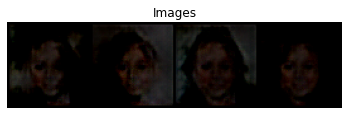

Epoch no - 31
Discriminator Loss : 21.600418 	 Generator_loss : 82.713036
Accuracy on Real Data : 0.847406 	 Accuracy on fake Data : 0.152225
Epoch no - 32
Discriminator Loss : 18.933521 	 Generator_loss : 92.066139
Accuracy on Real Data : 0.838609 	 Accuracy on fake Data : 0.216968
Epoch no - 33
Discriminator Loss : 23.111858 	 Generator_loss : 68.555367
Accuracy on Real Data : 0.454764 	 Accuracy on fake Data : 0.162503
Epoch no - 34
Discriminator Loss : 19.583042 	 Generator_loss : 81.069839
Accuracy on Real Data : 0.839913 	 Accuracy on fake Data : 0.171593
Epoch no - 35
Discriminator Loss : 17.851702 	 Generator_loss : 95.602974
Accuracy on Real Data : 0.903630 	 Accuracy on fake Data : 0.083426
Epoch no - 36
Discriminator Loss : 19.527416 	 Generator_loss : 85.616051
Accuracy on Real Data : 0.815730 	 Accuracy on fake Data : 0.335231
Epoch no - 37
Discriminator Loss : 16.822653 	 Generator_loss : 82.394257
Accuracy on Real Data : 0.828585 	 Accuracy on fake Data : 0.249011
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 40
Discriminator Loss : 15.488002 	 Generator_loss : 83.570198
Accuracy on Real Data : 0.851514 	 Accuracy on fake Data : 0.170189


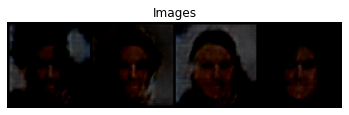

Epoch no - 41
Discriminator Loss : 16.634869 	 Generator_loss : 81.140778
Accuracy on Real Data : 0.085350 	 Accuracy on fake Data : 0.001943
Epoch no - 42
Discriminator Loss : 17.054459 	 Generator_loss : 78.294312
Accuracy on Real Data : 0.569674 	 Accuracy on fake Data : 0.059340
Epoch no - 43
Discriminator Loss : 11.832451 	 Generator_loss : 85.018654
Accuracy on Real Data : 0.911484 	 Accuracy on fake Data : 0.241509
Epoch no - 44
Discriminator Loss : 20.267620 	 Generator_loss : 83.936028
Accuracy on Real Data : 0.739794 	 Accuracy on fake Data : 0.411228
Epoch no - 45
Discriminator Loss : 14.923944 	 Generator_loss : 82.885094
Accuracy on Real Data : 0.944179 	 Accuracy on fake Data : 0.163959
Epoch no - 46
Discriminator Loss : 15.611077 	 Generator_loss : 81.840126
Accuracy on Real Data : 0.859147 	 Accuracy on fake Data : 0.231486
Epoch no - 47
Discriminator Loss : 15.696188 	 Generator_loss : 78.248398
Accuracy on Real Data : 0.812349 	 Accuracy on fake Data : 0.046295
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 50
Discriminator Loss : 14.500604 	 Generator_loss : 84.357414
Accuracy on Real Data : 0.520830 	 Accuracy on fake Data : 0.006963


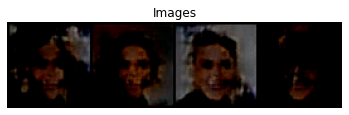

Epoch no - 51
Discriminator Loss : 11.412416 	 Generator_loss : 92.050735
Accuracy on Real Data : 0.131110 	 Accuracy on fake Data : 0.001430
Epoch no - 52
Discriminator Loss : 23.676075 	 Generator_loss : 58.197117
Accuracy on Real Data : 0.866730 	 Accuracy on fake Data : 0.280221
Epoch no - 53
Discriminator Loss : 23.825924 	 Generator_loss : 80.482704
Accuracy on Real Data : 0.357167 	 Accuracy on fake Data : 0.013174
Epoch no - 54
Discriminator Loss : 20.687370 	 Generator_loss : 92.066124
Accuracy on Real Data : 0.529045 	 Accuracy on fake Data : 0.084886
Epoch no - 55
Discriminator Loss : 21.199772 	 Generator_loss : 77.989716
Accuracy on Real Data : 0.964181 	 Accuracy on fake Data : 0.645345
Epoch no - 56
Discriminator Loss : 13.556201 	 Generator_loss : 76.438171
Accuracy on Real Data : 0.812738 	 Accuracy on fake Data : 0.176211
Epoch no - 57
Discriminator Loss : 19.228024 	 Generator_loss : 78.047501
Accuracy on Real Data : 0.426276 	 Accuracy on fake Data : 0.072291
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 60
Discriminator Loss : 18.279934 	 Generator_loss : 87.964401
Accuracy on Real Data : 0.548403 	 Accuracy on fake Data : 0.082247


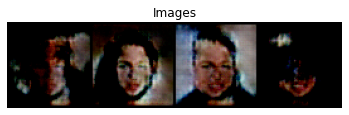

Epoch no - 61
Discriminator Loss : 14.669097 	 Generator_loss : 90.028786
Accuracy on Real Data : 0.935488 	 Accuracy on fake Data : 0.442977
Epoch no - 62
Discriminator Loss : 14.866930 	 Generator_loss : 88.762794
Accuracy on Real Data : 0.830996 	 Accuracy on fake Data : 0.108111
Epoch no - 63
Discriminator Loss : 17.897926 	 Generator_loss : 96.598824
Accuracy on Real Data : 0.817523 	 Accuracy on fake Data : 0.084038
Epoch no - 64
Discriminator Loss : 13.238726 	 Generator_loss : 88.331177
Accuracy on Real Data : 0.964324 	 Accuracy on fake Data : 0.407569
Epoch no - 65
Discriminator Loss : 12.609424 	 Generator_loss : 93.295349
Accuracy on Real Data : 0.633593 	 Accuracy on fake Data : 0.044389
Epoch no - 66
Discriminator Loss : 11.240095 	 Generator_loss : 97.057579
Accuracy on Real Data : 0.819340 	 Accuracy on fake Data : 0.082205
Epoch no - 67
Discriminator Loss : 15.363862 	 Generator_loss : 89.606071
Accuracy on Real Data : 0.433838 	 Accuracy on fake Data : 0.028553
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 70
Discriminator Loss : 16.584497 	 Generator_loss : 97.040329
Accuracy on Real Data : 0.643892 	 Accuracy on fake Data : 0.088748


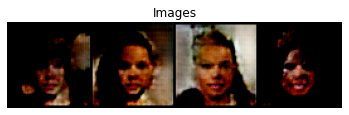

Epoch no - 71
Discriminator Loss : 11.984534 	 Generator_loss : 93.067711
Accuracy on Real Data : 0.940380 	 Accuracy on fake Data : 0.341750
Epoch no - 72
Discriminator Loss : 12.551085 	 Generator_loss : 95.074852
Accuracy on Real Data : 0.978330 	 Accuracy on fake Data : 0.359479
Epoch no - 73
Discriminator Loss : 10.578554 	 Generator_loss : 93.377571
Accuracy on Real Data : 0.827975 	 Accuracy on fake Data : 0.126257
Epoch no - 74
Discriminator Loss : 11.302499 	 Generator_loss : 101.137367
Accuracy on Real Data : 0.548224 	 Accuracy on fake Data : 0.020654
Epoch no - 75
Discriminator Loss : 11.265324 	 Generator_loss : 94.253220
Accuracy on Real Data : 0.847920 	 Accuracy on fake Data : 0.120435
Epoch no - 76
Discriminator Loss : 15.559960 	 Generator_loss : 100.106621
Accuracy on Real Data : 0.951374 	 Accuracy on fake Data : 0.401679
Epoch no - 77
Discriminator Loss : 11.755242 	 Generator_loss : 91.634567
Accuracy on Real Data : 0.780043 	 Accuracy on fake Data : 0.049906
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 80
Discriminator Loss : 8.144336 	 Generator_loss : 96.694534
Accuracy on Real Data : 0.938666 	 Accuracy on fake Data : 0.219583


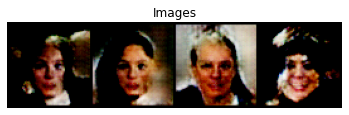

Epoch no - 81
Discriminator Loss : 22.623917 	 Generator_loss : 101.861015
Accuracy on Real Data : 0.810421 	 Accuracy on fake Data : 0.217873
Epoch no - 82
Discriminator Loss : 12.949885 	 Generator_loss : 95.987083
Accuracy on Real Data : 0.432232 	 Accuracy on fake Data : 0.002336
Epoch no - 83
Discriminator Loss : 12.704749 	 Generator_loss : 92.097412
Accuracy on Real Data : 0.951446 	 Accuracy on fake Data : 0.232068
Epoch no - 84
Discriminator Loss : 11.176513 	 Generator_loss : 91.569847
Accuracy on Real Data : 0.882499 	 Accuracy on fake Data : 0.172144
Epoch no - 85
Discriminator Loss : 11.780456 	 Generator_loss : 102.510582
Accuracy on Real Data : 0.722378 	 Accuracy on fake Data : 0.023429
Epoch no - 86
Discriminator Loss : 13.267502 	 Generator_loss : 95.979813
Accuracy on Real Data : 0.825589 	 Accuracy on fake Data : 0.153509
Epoch no - 87
Discriminator Loss : 9.974439 	 Generator_loss : 97.487099
Accuracy on Real Data : 0.742179 	 Accuracy on fake Data : 0.017571
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 90
Discriminator Loss : 16.446529 	 Generator_loss : 103.709885
Accuracy on Real Data : 0.969656 	 Accuracy on fake Data : 0.374126


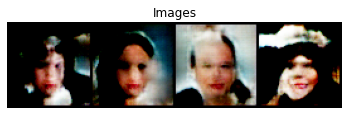

Epoch no - 91
Discriminator Loss : 8.695433 	 Generator_loss : 92.450653
Accuracy on Real Data : 0.890909 	 Accuracy on fake Data : 0.184069
Epoch no - 92
Discriminator Loss : 14.387049 	 Generator_loss : 95.196266
Accuracy on Real Data : 0.854593 	 Accuracy on fake Data : 0.146396
Epoch no - 93
Discriminator Loss : 11.135795 	 Generator_loss : 101.127457
Accuracy on Real Data : 0.960730 	 Accuracy on fake Data : 0.418197
Epoch no - 94
Discriminator Loss : 13.129393 	 Generator_loss : 101.036491
Accuracy on Real Data : 0.927507 	 Accuracy on fake Data : 0.174918
Epoch no - 95
Discriminator Loss : 13.751941 	 Generator_loss : 94.527290
Accuracy on Real Data : 0.969678 	 Accuracy on fake Data : 0.334441
Epoch no - 96
Discriminator Loss : 11.882700 	 Generator_loss : 89.725204
Accuracy on Real Data : 0.803262 	 Accuracy on fake Data : 0.087597
Epoch no - 97
Discriminator Loss : 8.342364 	 Generator_loss : 94.080948
Accuracy on Real Data : 0.964062 	 Accuracy on fake Data : 0.306602
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 100
Discriminator Loss : 12.173224 	 Generator_loss : 100.535141
Accuracy on Real Data : 0.909031 	 Accuracy on fake Data : 0.242143


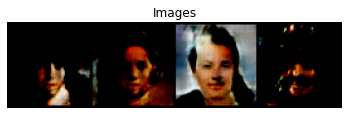

Epoch no - 101
Discriminator Loss : 8.951311 	 Generator_loss : 91.480400
Accuracy on Real Data : 0.869260 	 Accuracy on fake Data : 0.101164
Epoch no - 102
Discriminator Loss : 12.788005 	 Generator_loss : 96.915710
Accuracy on Real Data : 0.692523 	 Accuracy on fake Data : 0.022807
Epoch no - 103
Discriminator Loss : 11.937270 	 Generator_loss : 90.219635
Accuracy on Real Data : 0.510494 	 Accuracy on fake Data : 0.016369
Epoch no - 104
Discriminator Loss : 14.597106 	 Generator_loss : 101.267357
Accuracy on Real Data : 0.985694 	 Accuracy on fake Data : 0.489117
Epoch no - 105
Discriminator Loss : 13.981490 	 Generator_loss : 95.892212
Accuracy on Real Data : 0.907235 	 Accuracy on fake Data : 0.324741
Epoch no - 106
Discriminator Loss : 9.311612 	 Generator_loss : 89.096413
Accuracy on Real Data : 0.668698 	 Accuracy on fake Data : 0.013265
Epoch no - 107
Discriminator Loss : 15.000581 	 Generator_loss : 101.277954
Accuracy on Real Data : 0.582806 	 Accuracy on fake Data : 0.035337

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 110
Discriminator Loss : 8.583038 	 Generator_loss : 94.402184
Accuracy on Real Data : 0.870359 	 Accuracy on fake Data : 0.061671


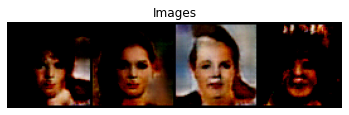

Epoch no - 111
Discriminator Loss : 16.989876 	 Generator_loss : 101.082695
Accuracy on Real Data : 0.914564 	 Accuracy on fake Data : 0.189063
Epoch no - 112
Discriminator Loss : 12.052519 	 Generator_loss : 94.933456
Accuracy on Real Data : 0.964529 	 Accuracy on fake Data : 0.255275
Epoch no - 113
Discriminator Loss : 11.671313 	 Generator_loss : 94.346710
Accuracy on Real Data : 0.731914 	 Accuracy on fake Data : 0.061404
Epoch no - 114
Discriminator Loss : 9.671029 	 Generator_loss : 95.585960
Accuracy on Real Data : 0.874421 	 Accuracy on fake Data : 0.136714
Epoch no - 115
Discriminator Loss : 18.849901 	 Generator_loss : 97.220413
Accuracy on Real Data : 0.936146 	 Accuracy on fake Data : 0.540765
Epoch no - 116
Discriminator Loss : 18.118635 	 Generator_loss : 100.743080
Accuracy on Real Data : 0.874937 	 Accuracy on fake Data : 0.267138
Epoch no - 117
Discriminator Loss : 10.542774 	 Generator_loss : 90.542915
Accuracy on Real Data : 0.674023 	 Accuracy on fake Data : 0.04538

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 120
Discriminator Loss : 10.364235 	 Generator_loss : 96.236443
Accuracy on Real Data : 0.952643 	 Accuracy on fake Data : 0.500465


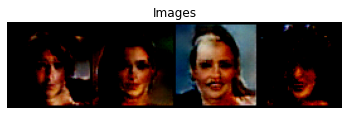

Epoch no - 121
Discriminator Loss : 16.358658 	 Generator_loss : 98.823120
Accuracy on Real Data : 0.691084 	 Accuracy on fake Data : 0.018414
Epoch no - 122
Discriminator Loss : 9.345066 	 Generator_loss : 93.213699
Accuracy on Real Data : 0.847967 	 Accuracy on fake Data : 0.127562
Epoch no - 123
Discriminator Loss : 9.013428 	 Generator_loss : 99.600891
Accuracy on Real Data : 0.973273 	 Accuracy on fake Data : 0.434776
Epoch no - 124
Discriminator Loss : 9.022911 	 Generator_loss : 95.494888
Accuracy on Real Data : 0.981066 	 Accuracy on fake Data : 0.540182
Epoch no - 125
Discriminator Loss : 20.281610 	 Generator_loss : 92.698730
Accuracy on Real Data : 0.856551 	 Accuracy on fake Data : 0.193812
Epoch no - 126
Discriminator Loss : 8.055914 	 Generator_loss : 88.420082
Accuracy on Real Data : 0.846307 	 Accuracy on fake Data : 0.248879
Epoch no - 127
Discriminator Loss : 16.663933 	 Generator_loss : 100.147247
Accuracy on Real Data : 0.451325 	 Accuracy on fake Data : 0.004867
Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 130
Discriminator Loss : 8.681319 	 Generator_loss : 94.271317
Accuracy on Real Data : 0.940279 	 Accuracy on fake Data : 0.196467


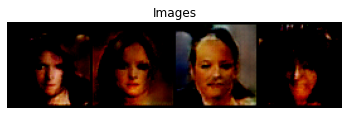

Epoch no - 131
Discriminator Loss : 14.433628 	 Generator_loss : 96.637772
Accuracy on Real Data : 0.740337 	 Accuracy on fake Data : 0.064199
Epoch no - 132
Discriminator Loss : 6.808478 	 Generator_loss : 93.519958
Accuracy on Real Data : 0.863184 	 Accuracy on fake Data : 0.112770
Epoch no - 133
Discriminator Loss : 5.444776 	 Generator_loss : 91.864868
Accuracy on Real Data : 0.845723 	 Accuracy on fake Data : 0.073658
Epoch no - 134
Discriminator Loss : 26.170275 	 Generator_loss : 102.576393
Accuracy on Real Data : 0.521547 	 Accuracy on fake Data : 0.204723
Epoch no - 135
Discriminator Loss : 20.066799 	 Generator_loss : 106.269318
Accuracy on Real Data : 0.861130 	 Accuracy on fake Data : 0.213500
Epoch no - 136
Discriminator Loss : 9.184145 	 Generator_loss : 84.830544
Accuracy on Real Data : 0.816681 	 Accuracy on fake Data : 0.113093
Epoch no - 137
Discriminator Loss : 8.465891 	 Generator_loss : 86.244537
Accuracy on Real Data : 0.765730 	 Accuracy on fake Data : 0.047658
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 140
Discriminator Loss : 19.941765 	 Generator_loss : 105.300980
Accuracy on Real Data : 0.956164 	 Accuracy on fake Data : 0.267896


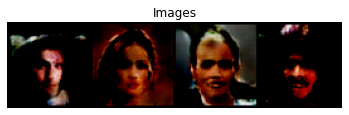

Epoch no - 141
Discriminator Loss : 8.020020 	 Generator_loss : 90.026367
Accuracy on Real Data : 0.913785 	 Accuracy on fake Data : 0.160648
Epoch no - 142
Discriminator Loss : 6.382100 	 Generator_loss : 96.553711
Accuracy on Real Data : 0.913402 	 Accuracy on fake Data : 0.050675
Epoch no - 143
Discriminator Loss : 7.422292 	 Generator_loss : 95.188004
Accuracy on Real Data : 0.457757 	 Accuracy on fake Data : 0.007792
Epoch no - 144
Discriminator Loss : 15.610826 	 Generator_loss : 112.744530
Accuracy on Real Data : 0.773251 	 Accuracy on fake Data : 0.221960
Epoch no - 145
Discriminator Loss : 11.741827 	 Generator_loss : 103.474464
Accuracy on Real Data : 0.898186 	 Accuracy on fake Data : 0.168167
Epoch no - 146
Discriminator Loss : 7.538136 	 Generator_loss : 96.971619
Accuracy on Real Data : 0.830426 	 Accuracy on fake Data : 0.040277
Epoch no - 147
Discriminator Loss : 6.410466 	 Generator_loss : 99.266479
Accuracy on Real Data : 0.940088 	 Accuracy on fake Data : 0.103820
Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 150
Discriminator Loss : 10.467549 	 Generator_loss : 92.066841
Accuracy on Real Data : 0.905926 	 Accuracy on fake Data : 0.114519


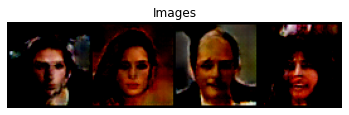

Epoch no - 151
Discriminator Loss : 6.708879 	 Generator_loss : 86.352470
Accuracy on Real Data : 0.752082 	 Accuracy on fake Data : 0.034673
Epoch no - 152
Discriminator Loss : 6.285442 	 Generator_loss : 93.778549
Accuracy on Real Data : 0.887736 	 Accuracy on fake Data : 0.077050
Epoch no - 153
Discriminator Loss : 5.243525 	 Generator_loss : 92.732910
Accuracy on Real Data : 0.928506 	 Accuracy on fake Data : 0.091671
Epoch no - 154
Discriminator Loss : 4.685678 	 Generator_loss : 95.491310
Accuracy on Real Data : 0.843763 	 Accuracy on fake Data : 0.043281
Epoch no - 155
Discriminator Loss : 8.762642 	 Generator_loss : 104.670662
Accuracy on Real Data : 0.184335 	 Accuracy on fake Data : 0.000497
Epoch no - 156
Discriminator Loss : 34.565273 	 Generator_loss : 100.470055
Accuracy on Real Data : 0.868332 	 Accuracy on fake Data : 0.367377
Epoch no - 157
Discriminator Loss : 11.943201 	 Generator_loss : 99.135269
Accuracy on Real Data : 0.964307 	 Accuracy on fake Data : 0.346932
Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 160
Discriminator Loss : 4.891121 	 Generator_loss : 93.414825
Accuracy on Real Data : 0.939088 	 Accuracy on fake Data : 0.179579


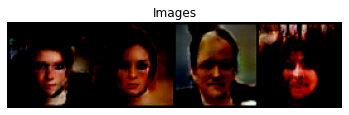

Epoch no - 161
Discriminator Loss : 4.560393 	 Generator_loss : 97.307114
Accuracy on Real Data : 0.955160 	 Accuracy on fake Data : 0.064550
Epoch no - 162
Discriminator Loss : 4.401046 	 Generator_loss : 99.253967
Accuracy on Real Data : 0.941605 	 Accuracy on fake Data : 0.153337
Epoch no - 163
Discriminator Loss : 14.068005 	 Generator_loss : 105.213470
Accuracy on Real Data : 0.173835 	 Accuracy on fake Data : 0.000622
Epoch no - 164
Discriminator Loss : 36.769779 	 Generator_loss : 110.489456
Accuracy on Real Data : 0.763416 	 Accuracy on fake Data : 0.319059
Epoch no - 165
Discriminator Loss : 11.341372 	 Generator_loss : 94.229134
Accuracy on Real Data : 0.775701 	 Accuracy on fake Data : 0.123820
Epoch no - 166
Discriminator Loss : 7.284634 	 Generator_loss : 90.918991
Accuracy on Real Data : 0.954946 	 Accuracy on fake Data : 0.175972
Epoch no - 167
Discriminator Loss : 6.566593 	 Generator_loss : 91.239738
Accuracy on Real Data : 0.852723 	 Accuracy on fake Data : 0.060829
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 170
Discriminator Loss : 4.711869 	 Generator_loss : 100.613747
Accuracy on Real Data : 0.827143 	 Accuracy on fake Data : 0.029739


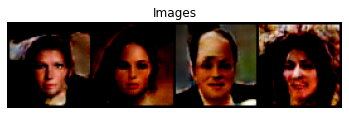

Epoch no - 171
Discriminator Loss : 5.489048 	 Generator_loss : 105.995033
Accuracy on Real Data : 0.797042 	 Accuracy on fake Data : 0.046748
Epoch no - 172
Discriminator Loss : 5.106981 	 Generator_loss : 104.584595
Accuracy on Real Data : 0.918986 	 Accuracy on fake Data : 0.078854
Epoch no - 173
Discriminator Loss : 3.481947 	 Generator_loss : 103.191833
Accuracy on Real Data : 0.926903 	 Accuracy on fake Data : 0.027138
Epoch no - 174
Discriminator Loss : 3.258255 	 Generator_loss : 103.484962
Accuracy on Real Data : 0.927522 	 Accuracy on fake Data : 0.101063
Epoch no - 175
Discriminator Loss : 3.457552 	 Generator_loss : 105.775833
Accuracy on Real Data : 0.929986 	 Accuracy on fake Data : 0.111404
Epoch no - 176
Discriminator Loss : 50.770908 	 Generator_loss : 84.799019
Accuracy on Real Data : 0.436509 	 Accuracy on fake Data : 0.444420
Epoch no - 177
Discriminator Loss : 37.193760 	 Generator_loss : 60.759895
Accuracy on Real Data : 0.487627 	 Accuracy on fake Data : 0.180652

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 180
Discriminator Loss : 10.709702 	 Generator_loss : 87.860352
Accuracy on Real Data : 0.913224 	 Accuracy on fake Data : 0.264985


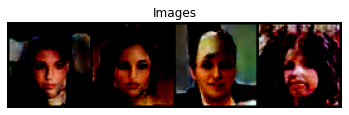

Epoch no - 181
Discriminator Loss : 7.062939 	 Generator_loss : 83.961372
Accuracy on Real Data : 0.888518 	 Accuracy on fake Data : 0.078740
Epoch no - 182
Discriminator Loss : 5.782923 	 Generator_loss : 84.230507
Accuracy on Real Data : 0.802529 	 Accuracy on fake Data : 0.046672
Epoch no - 183
Discriminator Loss : 7.105706 	 Generator_loss : 94.662903
Accuracy on Real Data : 0.969406 	 Accuracy on fake Data : 0.181821
Epoch no - 184
Discriminator Loss : 6.860525 	 Generator_loss : 97.632385
Accuracy on Real Data : 0.962990 	 Accuracy on fake Data : 0.132713
Epoch no - 185
Discriminator Loss : 4.550222 	 Generator_loss : 97.506660
Accuracy on Real Data : 0.971944 	 Accuracy on fake Data : 0.135243
Epoch no - 186
Discriminator Loss : 3.803076 	 Generator_loss : 98.247955
Accuracy on Real Data : 0.974156 	 Accuracy on fake Data : 0.140704
Epoch no - 187
Discriminator Loss : 3.587406 	 Generator_loss : 98.897957
Accuracy on Real Data : 0.906461 	 Accuracy on fake Data : 0.061853
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 190
Discriminator Loss : 5.268870 	 Generator_loss : 97.674179
Accuracy on Real Data : 0.902005 	 Accuracy on fake Data : 0.048408


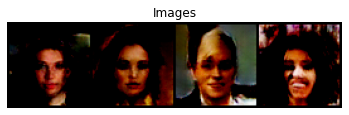

Epoch no - 191
Discriminator Loss : 3.705326 	 Generator_loss : 95.953911
Accuracy on Real Data : 0.909950 	 Accuracy on fake Data : 0.038853
Epoch no - 192
Discriminator Loss : 3.525162 	 Generator_loss : 98.853989
Accuracy on Real Data : 0.917346 	 Accuracy on fake Data : 0.049788
Epoch no - 193
Discriminator Loss : 2.773391 	 Generator_loss : 96.398689
Accuracy on Real Data : 0.936259 	 Accuracy on fake Data : 0.034864
Epoch no - 194
Discriminator Loss : 2.717179 	 Generator_loss : 100.586807
Accuracy on Real Data : 0.976988 	 Accuracy on fake Data : 0.109580
Epoch no - 195
Discriminator Loss : 2.856510 	 Generator_loss : 103.980637
Accuracy on Real Data : 0.974131 	 Accuracy on fake Data : 0.062658
Epoch no - 196
Discriminator Loss : 23.188234 	 Generator_loss : 104.627747
Accuracy on Real Data : 0.915997 	 Accuracy on fake Data : 0.845531
Epoch no - 197
Discriminator Loss : 34.707943 	 Generator_loss : 52.914276
Accuracy on Real Data : 0.807227 	 Accuracy on fake Data : 0.397575
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 200
Discriminator Loss : 8.450272 	 Generator_loss : 96.233467
Accuracy on Real Data : 0.931062 	 Accuracy on fake Data : 0.216890


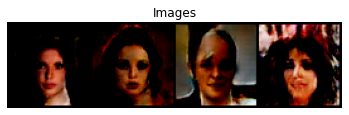

Epoch no - 201
Discriminator Loss : 5.574783 	 Generator_loss : 95.563980
Accuracy on Real Data : 0.917406 	 Accuracy on fake Data : 0.107877
Epoch no - 202
Discriminator Loss : 4.897635 	 Generator_loss : 94.955971
Accuracy on Real Data : 0.922678 	 Accuracy on fake Data : 0.125111
Epoch no - 203
Discriminator Loss : 3.733890 	 Generator_loss : 97.219719
Accuracy on Real Data : 0.960415 	 Accuracy on fake Data : 0.133920
Epoch no - 204
Discriminator Loss : 3.298144 	 Generator_loss : 95.791168
Accuracy on Real Data : 0.834998 	 Accuracy on fake Data : 0.067261
Epoch no - 205
Discriminator Loss : 18.138824 	 Generator_loss : 120.620628
Accuracy on Real Data : 0.616459 	 Accuracy on fake Data : 0.023167
Epoch no - 206
Discriminator Loss : 7.991643 	 Generator_loss : 116.411606
Accuracy on Real Data : 0.952890 	 Accuracy on fake Data : 0.113126
Epoch no - 207
Discriminator Loss : 3.578248 	 Generator_loss : 100.885422
Accuracy on Real Data : 0.953758 	 Accuracy on fake Data : 0.089124
Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 210
Discriminator Loss : 2.290897 	 Generator_loss : 102.578346
Accuracy on Real Data : 0.930828 	 Accuracy on fake Data : 0.037476


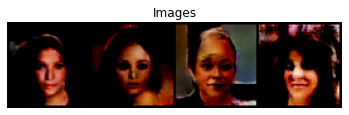

Epoch no - 211
Discriminator Loss : 2.257253 	 Generator_loss : 102.521950
Accuracy on Real Data : 0.945146 	 Accuracy on fake Data : 0.046681
Epoch no - 212
Discriminator Loss : 8.244086 	 Generator_loss : 114.249588
Accuracy on Real Data : 0.398411 	 Accuracy on fake Data : 0.012459
Epoch no - 213
Discriminator Loss : 35.900093 	 Generator_loss : 128.757126
Accuracy on Real Data : 0.851581 	 Accuracy on fake Data : 0.302832
Epoch no - 214
Discriminator Loss : 10.596339 	 Generator_loss : 110.339973
Accuracy on Real Data : 0.894205 	 Accuracy on fake Data : 0.131727
Epoch no - 215
Discriminator Loss : 5.186551 	 Generator_loss : 98.004776
Accuracy on Real Data : 0.848415 	 Accuracy on fake Data : 0.039903
Epoch no - 216
Discriminator Loss : 3.939971 	 Generator_loss : 96.952904
Accuracy on Real Data : 0.931499 	 Accuracy on fake Data : 0.045541
Epoch no - 217
Discriminator Loss : 3.118269 	 Generator_loss : 98.440819
Accuracy on Real Data : 0.955807 	 Accuracy on fake Data : 0.048380


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 220
Discriminator Loss : 2.033275 	 Generator_loss : 102.524406
Accuracy on Real Data : 0.967292 	 Accuracy on fake Data : 0.041428


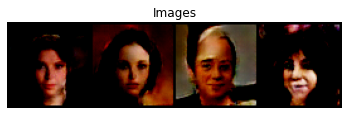

Epoch no - 221
Discriminator Loss : 2.163932 	 Generator_loss : 106.479332
Accuracy on Real Data : 0.990753 	 Accuracy on fake Data : 0.106536
Epoch no - 222
Discriminator Loss : 1.962903 	 Generator_loss : 107.348740
Accuracy on Real Data : 0.968468 	 Accuracy on fake Data : 0.034280
Epoch no - 223
Discriminator Loss : 1.851446 	 Generator_loss : 106.555267
Accuracy on Real Data : 0.963498 	 Accuracy on fake Data : 0.056291
Epoch no - 224
Discriminator Loss : 2.088900 	 Generator_loss : 109.068649
Accuracy on Real Data : 0.819276 	 Accuracy on fake Data : 0.007843
Epoch no - 225
Discriminator Loss : 51.523605 	 Generator_loss : 86.706665
Accuracy on Real Data : 0.592330 	 Accuracy on fake Data : 0.180639
Epoch no - 226
Discriminator Loss : 18.169531 	 Generator_loss : 122.632065
Accuracy on Real Data : 0.908933 	 Accuracy on fake Data : 0.367661
Epoch no - 227
Discriminator Loss : 7.595961 	 Generator_loss : 104.658592
Accuracy on Real Data : 0.899257 	 Accuracy on fake Data : 0.06383

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 230
Discriminator Loss : 2.674380 	 Generator_loss : 102.203606
Accuracy on Real Data : 0.951408 	 Accuracy on fake Data : 0.025737


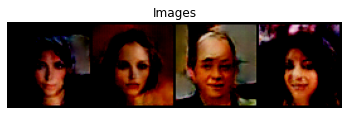

Epoch no - 231
Discriminator Loss : 2.326599 	 Generator_loss : 103.119728
Accuracy on Real Data : 0.971144 	 Accuracy on fake Data : 0.057163
Epoch no - 232
Discriminator Loss : 2.342843 	 Generator_loss : 107.435776
Accuracy on Real Data : 0.956753 	 Accuracy on fake Data : 0.036249
Epoch no - 233
Discriminator Loss : 1.971809 	 Generator_loss : 105.306091
Accuracy on Real Data : 0.947474 	 Accuracy on fake Data : 0.038646
Epoch no - 234
Discriminator Loss : 2.219127 	 Generator_loss : 109.790749
Accuracy on Real Data : 0.948040 	 Accuracy on fake Data : 0.019092
Epoch no - 235
Discriminator Loss : 1.739216 	 Generator_loss : 109.430588
Accuracy on Real Data : 0.992482 	 Accuracy on fake Data : 0.069940
Epoch no - 236
Discriminator Loss : 1.703651 	 Generator_loss : 112.527199
Accuracy on Real Data : 0.957690 	 Accuracy on fake Data : 0.015971
Epoch no - 237
Discriminator Loss : 1.452724 	 Generator_loss : 113.129616
Accuracy on Real Data : 0.984251 	 Accuracy on fake Data : 0.050391

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 240
Discriminator Loss : 50.356487 	 Generator_loss : 84.941078
Accuracy on Real Data : 0.676628 	 Accuracy on fake Data : 0.525604


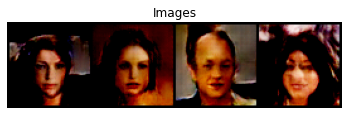

Epoch no - 241
Discriminator Loss : 33.396389 	 Generator_loss : 115.807251
Accuracy on Real Data : 0.856479 	 Accuracy on fake Data : 0.416499
Epoch no - 242
Discriminator Loss : 17.472404 	 Generator_loss : 121.065819
Accuracy on Real Data : 0.775505 	 Accuracy on fake Data : 0.142217
Epoch no - 243
Discriminator Loss : 7.619424 	 Generator_loss : 108.031120
Accuracy on Real Data : 0.849259 	 Accuracy on fake Data : 0.122953
Epoch no - 244
Discriminator Loss : 4.578366 	 Generator_loss : 103.830894
Accuracy on Real Data : 0.943903 	 Accuracy on fake Data : 0.082243
Epoch no - 245
Discriminator Loss : 3.270785 	 Generator_loss : 99.272011
Accuracy on Real Data : 0.971792 	 Accuracy on fake Data : 0.079885
Epoch no - 246
Discriminator Loss : 2.967506 	 Generator_loss : 100.991676
Accuracy on Real Data : 0.941723 	 Accuracy on fake Data : 0.047247
Epoch no - 247
Discriminator Loss : 2.525977 	 Generator_loss : 101.650528
Accuracy on Real Data : 0.919366 	 Accuracy on fake Data : 0.02631

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 250
Discriminator Loss : 1.756890 	 Generator_loss : 107.887512
Accuracy on Real Data : 0.982905 	 Accuracy on fake Data : 0.036359


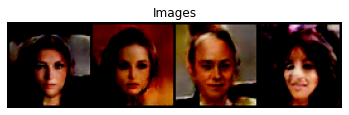

Epoch no - 251
Discriminator Loss : 1.621112 	 Generator_loss : 109.117241
Accuracy on Real Data : 0.962834 	 Accuracy on fake Data : 0.024616
Epoch no - 252
Discriminator Loss : 1.717633 	 Generator_loss : 111.578499
Accuracy on Real Data : 0.954409 	 Accuracy on fake Data : 0.036540
Epoch no - 253
Discriminator Loss : 1.456295 	 Generator_loss : 112.564583
Accuracy on Real Data : 0.989157 	 Accuracy on fake Data : 0.043725
Epoch no - 254
Discriminator Loss : 1.297317 	 Generator_loss : 113.099365
Accuracy on Real Data : 0.979680 	 Accuracy on fake Data : 0.018830
Epoch no - 255
Discriminator Loss : 31.216139 	 Generator_loss : 98.572792
Accuracy on Real Data : 0.756835 	 Accuracy on fake Data : 0.562626
Epoch no - 256
Discriminator Loss : 23.735542 	 Generator_loss : 112.959435
Accuracy on Real Data : 0.800864 	 Accuracy on fake Data : 0.243175
Epoch no - 257
Discriminator Loss : 13.106930 	 Generator_loss : 132.821335
Accuracy on Real Data : 0.847304 	 Accuracy on fake Data : 0.0744

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 260
Discriminator Loss : 2.452739 	 Generator_loss : 109.510834
Accuracy on Real Data : 0.955261 	 Accuracy on fake Data : 0.029759


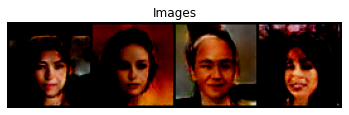

Epoch no - 261
Discriminator Loss : 2.123445 	 Generator_loss : 108.221275
Accuracy on Real Data : 0.968856 	 Accuracy on fake Data : 0.029913
Epoch no - 262
Discriminator Loss : 1.821363 	 Generator_loss : 109.625381
Accuracy on Real Data : 0.982790 	 Accuracy on fake Data : 0.052205
Epoch no - 263
Discriminator Loss : 2.306037 	 Generator_loss : 111.751709
Accuracy on Real Data : 0.968506 	 Accuracy on fake Data : 0.043661
Epoch no - 264
Discriminator Loss : 2.140456 	 Generator_loss : 115.074120
Accuracy on Real Data : 0.985258 	 Accuracy on fake Data : 0.047214
Epoch no - 265
Discriminator Loss : 1.424761 	 Generator_loss : 117.281075
Accuracy on Real Data : 0.968677 	 Accuracy on fake Data : 0.030141
Epoch no - 266
Discriminator Loss : 1.212684 	 Generator_loss : 114.133789
Accuracy on Real Data : 0.974821 	 Accuracy on fake Data : 0.018681
Epoch no - 267
Discriminator Loss : 1.161559 	 Generator_loss : 114.904816
Accuracy on Real Data : 0.978635 	 Accuracy on fake Data : 0.033578

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 270
Discriminator Loss : 0.976254 	 Generator_loss : 119.720360
Accuracy on Real Data : 0.977622 	 Accuracy on fake Data : 0.042114


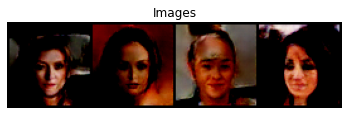

Epoch no - 271
Discriminator Loss : 0.907131 	 Generator_loss : 119.200172
Accuracy on Real Data : 0.965337 	 Accuracy on fake Data : 0.016415
Epoch no - 272
Discriminator Loss : 1.010164 	 Generator_loss : 120.394516
Accuracy on Real Data : 0.995771 	 Accuracy on fake Data : 0.033468
Epoch no - 273
Discriminator Loss : 1.662507 	 Generator_loss : 127.099281
Accuracy on Real Data : 0.994927 	 Accuracy on fake Data : 0.153643
Epoch no - 274
Discriminator Loss : 53.815460 	 Generator_loss : 82.394310
Accuracy on Real Data : 0.448180 	 Accuracy on fake Data : 0.260170
Epoch no - 275
Discriminator Loss : 31.554541 	 Generator_loss : 89.081863
Accuracy on Real Data : 0.614904 	 Accuracy on fake Data : 0.093242
Epoch no - 276
Discriminator Loss : 22.833078 	 Generator_loss : 129.730576
Accuracy on Real Data : 0.826467 	 Accuracy on fake Data : 0.231919
Epoch no - 277
Discriminator Loss : 11.392553 	 Generator_loss : 128.153320
Accuracy on Real Data : 0.820712 	 Accuracy on fake Data : 0.0360

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 280
Discriminator Loss : 3.685788 	 Generator_loss : 109.508835
Accuracy on Real Data : 0.904664 	 Accuracy on fake Data : 0.038131


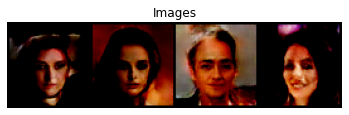

Epoch no - 281
Discriminator Loss : 2.523357 	 Generator_loss : 106.577560
Accuracy on Real Data : 0.990031 	 Accuracy on fake Data : 0.099380
Epoch no - 282
Discriminator Loss : 2.002233 	 Generator_loss : 107.059418
Accuracy on Real Data : 0.983697 	 Accuracy on fake Data : 0.050110
Epoch no - 283
Discriminator Loss : 1.681823 	 Generator_loss : 108.037254
Accuracy on Real Data : 0.936784 	 Accuracy on fake Data : 0.025515
Epoch no - 284
Discriminator Loss : 1.800563 	 Generator_loss : 112.054581
Accuracy on Real Data : 0.978464 	 Accuracy on fake Data : 0.055214
Epoch no - 285
Discriminator Loss : 1.477409 	 Generator_loss : 111.890388
Accuracy on Real Data : 0.912113 	 Accuracy on fake Data : 0.007101
Epoch no - 286
Discriminator Loss : 1.373607 	 Generator_loss : 111.150681
Accuracy on Real Data : 0.945163 	 Accuracy on fake Data : 0.016809
Epoch no - 287
Discriminator Loss : 1.208473 	 Generator_loss : 113.763901
Accuracy on Real Data : 0.980500 	 Accuracy on fake Data : 0.023350

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 290
Discriminator Loss : 1.191970 	 Generator_loss : 118.875900
Accuracy on Real Data : 0.959246 	 Accuracy on fake Data : 0.016163


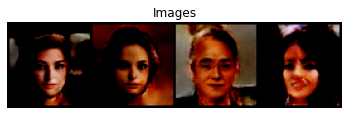

Epoch no - 291
Discriminator Loss : 0.905668 	 Generator_loss : 119.969536
Accuracy on Real Data : 0.994971 	 Accuracy on fake Data : 0.038260
Epoch no - 292
Discriminator Loss : 0.831858 	 Generator_loss : 122.350723
Accuracy on Real Data : 0.972035 	 Accuracy on fake Data : 0.023461
Epoch no - 293
Discriminator Loss : 0.888967 	 Generator_loss : 122.694016
Accuracy on Real Data : 0.981000 	 Accuracy on fake Data : 0.005670
Epoch no - 294
Discriminator Loss : 0.785740 	 Generator_loss : 121.306389
Accuracy on Real Data : 0.984607 	 Accuracy on fake Data : 0.017548
Epoch no - 295
Discriminator Loss : 0.825323 	 Generator_loss : 122.784943
Accuracy on Real Data : 0.977859 	 Accuracy on fake Data : 0.016151
Epoch no - 296
Discriminator Loss : 0.724028 	 Generator_loss : 126.257698
Accuracy on Real Data : 0.988029 	 Accuracy on fake Data : 0.017271
Epoch no - 297
Discriminator Loss : 0.667336 	 Generator_loss : 124.801086
Accuracy on Real Data : 0.994860 	 Accuracy on fake Data : 0.017833

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 300
Discriminator Loss : 0.802804 	 Generator_loss : 130.291855
Accuracy on Real Data : 0.979513 	 Accuracy on fake Data : 0.012347


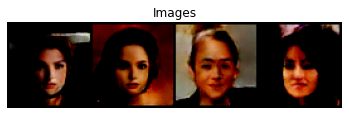

Epoch no - 301
Discriminator Loss : 0.690642 	 Generator_loss : 131.156296
Accuracy on Real Data : 0.983734 	 Accuracy on fake Data : 0.006597
Epoch no - 302
Discriminator Loss : 0.609993 	 Generator_loss : 131.935074
Accuracy on Real Data : 0.992851 	 Accuracy on fake Data : 0.014692
Epoch no - 303
Discriminator Loss : 0.694023 	 Generator_loss : 130.131836
Accuracy on Real Data : 0.976166 	 Accuracy on fake Data : 0.022505
Epoch no - 304
Discriminator Loss : 0.702256 	 Generator_loss : 134.112808
Accuracy on Real Data : 0.975648 	 Accuracy on fake Data : 0.010258
Epoch no - 305
Discriminator Loss : 0.601170 	 Generator_loss : 134.178314
Accuracy on Real Data : 0.988373 	 Accuracy on fake Data : 0.006529
Epoch no - 306
Discriminator Loss : 0.543005 	 Generator_loss : 134.152573
Accuracy on Real Data : 0.993513 	 Accuracy on fake Data : 0.026104
Epoch no - 307
Discriminator Loss : 0.677907 	 Generator_loss : 131.765488
Accuracy on Real Data : 0.978764 	 Accuracy on fake Data : 0.006398

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 310
Discriminator Loss : 43.922310 	 Generator_loss : 27.864004
Accuracy on Real Data : 0.526383 	 Accuracy on fake Data : 0.595349


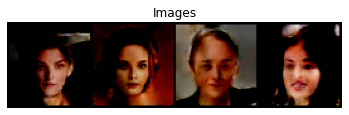

Epoch no - 311
Discriminator Loss : 33.478149 	 Generator_loss : 26.006601
Accuracy on Real Data : 0.482259 	 Accuracy on fake Data : 0.318274
Epoch no - 312
Discriminator Loss : 32.574402 	 Generator_loss : 28.639130
Accuracy on Real Data : 0.334085 	 Accuracy on fake Data : 0.143310
Epoch no - 313
Discriminator Loss : 32.400394 	 Generator_loss : 38.591167
Accuracy on Real Data : 0.705114 	 Accuracy on fake Data : 0.557360
Epoch no - 314
Discriminator Loss : 30.232769 	 Generator_loss : 42.322079
Accuracy on Real Data : 0.686479 	 Accuracy on fake Data : 0.518859
Epoch no - 315
Discriminator Loss : 30.591217 	 Generator_loss : 53.620777
Accuracy on Real Data : 0.683705 	 Accuracy on fake Data : 0.352556
Epoch no - 316
Discriminator Loss : 30.316545 	 Generator_loss : 56.302322
Accuracy on Real Data : 0.724973 	 Accuracy on fake Data : 0.482044
Epoch no - 317
Discriminator Loss : 29.669567 	 Generator_loss : 72.667656
Accuracy on Real Data : 0.653304 	 Accuracy on fake Data : 0.229092

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 320
Discriminator Loss : 23.651157 	 Generator_loss : 85.576370
Accuracy on Real Data : 0.798516 	 Accuracy on fake Data : 0.461939


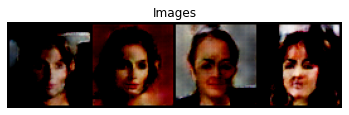

Epoch no - 321
Discriminator Loss : 26.185905 	 Generator_loss : 88.239883
Accuracy on Real Data : 0.786529 	 Accuracy on fake Data : 0.245943
Epoch no - 322
Discriminator Loss : 16.333437 	 Generator_loss : 107.592300
Accuracy on Real Data : 0.929382 	 Accuracy on fake Data : 0.466900
Epoch no - 323
Discriminator Loss : 16.230005 	 Generator_loss : 115.443382
Accuracy on Real Data : 0.964312 	 Accuracy on fake Data : 0.418996
Epoch no - 324
Discriminator Loss : 10.480495 	 Generator_loss : 114.008949
Accuracy on Real Data : 0.918792 	 Accuracy on fake Data : 0.120741
Epoch no - 325
Discriminator Loss : 9.309786 	 Generator_loss : 110.054222
Accuracy on Real Data : 0.943374 	 Accuracy on fake Data : 0.066866
Epoch no - 326
Discriminator Loss : 5.517707 	 Generator_loss : 112.824165
Accuracy on Real Data : 0.899252 	 Accuracy on fake Data : 0.029297
Epoch no - 327
Discriminator Loss : 3.713320 	 Generator_loss : 108.445908
Accuracy on Real Data : 0.956361 	 Accuracy on fake Data : 0.111

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 330
Discriminator Loss : 2.370582 	 Generator_loss : 112.195168
Accuracy on Real Data : 0.965481 	 Accuracy on fake Data : 0.057444


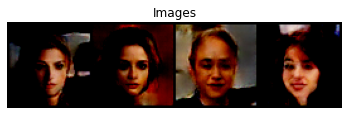

Epoch no - 331
Discriminator Loss : 3.064552 	 Generator_loss : 108.348640
Accuracy on Real Data : 0.779200 	 Accuracy on fake Data : 0.011491
Epoch no - 332
Discriminator Loss : 28.689581 	 Generator_loss : 101.102051
Accuracy on Real Data : 0.719923 	 Accuracy on fake Data : 0.058356
Epoch no - 333
Discriminator Loss : 7.599529 	 Generator_loss : 130.488678
Accuracy on Real Data : 0.925309 	 Accuracy on fake Data : 0.120115
Epoch no - 334
Discriminator Loss : 3.426740 	 Generator_loss : 121.464500
Accuracy on Real Data : 0.965249 	 Accuracy on fake Data : 0.039859
Epoch no - 335
Discriminator Loss : 2.072124 	 Generator_loss : 111.699226
Accuracy on Real Data : 0.976291 	 Accuracy on fake Data : 0.045715
Epoch no - 336
Discriminator Loss : 1.632374 	 Generator_loss : 112.637169
Accuracy on Real Data : 0.981381 	 Accuracy on fake Data : 0.048632
Epoch no - 337
Discriminator Loss : 1.549431 	 Generator_loss : 113.871704
Accuracy on Real Data : 0.973649 	 Accuracy on fake Data : 0.05114

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 340
Discriminator Loss : 1.268359 	 Generator_loss : 111.259399
Accuracy on Real Data : 0.884041 	 Accuracy on fake Data : 0.016427


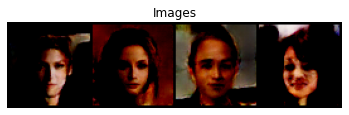

Epoch no - 341
Discriminator Loss : 44.105473 	 Generator_loss : 74.268806
Accuracy on Real Data : 0.697066 	 Accuracy on fake Data : 0.177265
Epoch no - 342
Discriminator Loss : 9.743810 	 Generator_loss : 104.500832
Accuracy on Real Data : 0.829833 	 Accuracy on fake Data : 0.045155
Epoch no - 343
Discriminator Loss : 3.681136 	 Generator_loss : 115.194801
Accuracy on Real Data : 0.936283 	 Accuracy on fake Data : 0.062510
Epoch no - 344
Discriminator Loss : 2.389987 	 Generator_loss : 115.233604
Accuracy on Real Data : 0.951043 	 Accuracy on fake Data : 0.024478
Epoch no - 345
Discriminator Loss : 1.831823 	 Generator_loss : 113.696503
Accuracy on Real Data : 0.966011 	 Accuracy on fake Data : 0.018790
Epoch no - 346
Discriminator Loss : 1.559503 	 Generator_loss : 114.784775
Accuracy on Real Data : 0.951162 	 Accuracy on fake Data : 0.027430
Epoch no - 347
Discriminator Loss : 1.239733 	 Generator_loss : 113.562126
Accuracy on Real Data : 0.963841 	 Accuracy on fake Data : 0.024573

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 350
Discriminator Loss : 0.905106 	 Generator_loss : 117.609390
Accuracy on Real Data : 0.976831 	 Accuracy on fake Data : 0.036871


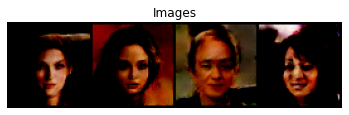

Epoch no - 351
Discriminator Loss : 0.850978 	 Generator_loss : 119.747223
Accuracy on Real Data : 0.979936 	 Accuracy on fake Data : 0.027869
Epoch no - 352
Discriminator Loss : 0.755106 	 Generator_loss : 118.328575
Accuracy on Real Data : 0.982719 	 Accuracy on fake Data : 0.022510
Epoch no - 353
Discriminator Loss : 0.757470 	 Generator_loss : 119.406128
Accuracy on Real Data : 0.983295 	 Accuracy on fake Data : 0.012378
Epoch no - 354
Discriminator Loss : 0.728639 	 Generator_loss : 119.816109
Accuracy on Real Data : 0.992164 	 Accuracy on fake Data : 0.018029
Epoch no - 355
Discriminator Loss : 0.785677 	 Generator_loss : 121.327141
Accuracy on Real Data : 0.979750 	 Accuracy on fake Data : 0.014722
Epoch no - 356
Discriminator Loss : 0.676319 	 Generator_loss : 125.228020
Accuracy on Real Data : 0.994783 	 Accuracy on fake Data : 0.009235
Epoch no - 357
Discriminator Loss : 0.633019 	 Generator_loss : 123.098282
Accuracy on Real Data : 0.991982 	 Accuracy on fake Data : 0.018620

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 360
Discriminator Loss : 0.584561 	 Generator_loss : 125.220474
Accuracy on Real Data : 0.995688 	 Accuracy on fake Data : 0.048965


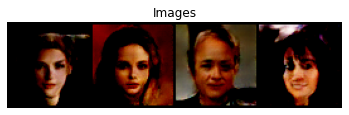

Epoch no - 361
Discriminator Loss : 0.678061 	 Generator_loss : 128.236282
Accuracy on Real Data : 0.985261 	 Accuracy on fake Data : 0.013481
Epoch no - 362
Discriminator Loss : 0.527054 	 Generator_loss : 129.220840
Accuracy on Real Data : 0.993275 	 Accuracy on fake Data : 0.013400
Epoch no - 363
Discriminator Loss : 0.559367 	 Generator_loss : 129.974289
Accuracy on Real Data : 0.989361 	 Accuracy on fake Data : 0.021802
Epoch no - 364
Discriminator Loss : 0.546243 	 Generator_loss : 129.472427
Accuracy on Real Data : 0.980142 	 Accuracy on fake Data : 0.005282
Epoch no - 365
Discriminator Loss : 0.531261 	 Generator_loss : 130.182312
Accuracy on Real Data : 0.991993 	 Accuracy on fake Data : 0.021205
Epoch no - 366
Discriminator Loss : 0.487485 	 Generator_loss : 131.562775
Accuracy on Real Data : 0.982894 	 Accuracy on fake Data : 0.006778
Epoch no - 367
Discriminator Loss : 0.481760 	 Generator_loss : 129.816727
Accuracy on Real Data : 0.977280 	 Accuracy on fake Data : 0.006467

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 370
Discriminator Loss : 0.528941 	 Generator_loss : 135.090500
Accuracy on Real Data : 0.993458 	 Accuracy on fake Data : 0.010063


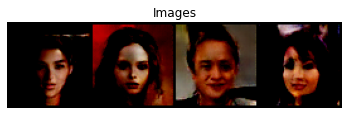

Epoch no - 371
Discriminator Loss : 0.454938 	 Generator_loss : 135.610046
Accuracy on Real Data : 0.977326 	 Accuracy on fake Data : 0.005441
Epoch no - 372
Discriminator Loss : 0.446715 	 Generator_loss : 138.189896
Accuracy on Real Data : 0.991688 	 Accuracy on fake Data : 0.005925
Epoch no - 373
Discriminator Loss : 0.462375 	 Generator_loss : 136.129578
Accuracy on Real Data : 0.978539 	 Accuracy on fake Data : 0.007409
Epoch no - 374
Discriminator Loss : 0.430517 	 Generator_loss : 140.697052
Accuracy on Real Data : 0.994123 	 Accuracy on fake Data : 0.006963
Epoch no - 375
Discriminator Loss : 0.385180 	 Generator_loss : 137.935684
Accuracy on Real Data : 0.986926 	 Accuracy on fake Data : 0.004434
Epoch no - 376
Discriminator Loss : 0.465877 	 Generator_loss : 136.985687
Accuracy on Real Data : 0.997678 	 Accuracy on fake Data : 0.023595
Epoch no - 377
Discriminator Loss : 0.387440 	 Generator_loss : 141.620300
Accuracy on Real Data : 0.990864 	 Accuracy on fake Data : 0.009662

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 380
Discriminator Loss : 36.864906 	 Generator_loss : 30.528587
Accuracy on Real Data : 0.497550 	 Accuracy on fake Data : 0.397802


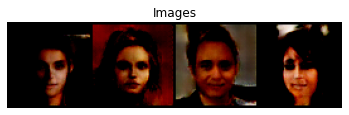

Epoch no - 381
Discriminator Loss : 31.105034 	 Generator_loss : 37.713108
Accuracy on Real Data : 0.386198 	 Accuracy on fake Data : 0.145325
Epoch no - 382
Discriminator Loss : 32.103615 	 Generator_loss : 59.194000
Accuracy on Real Data : 0.417976 	 Accuracy on fake Data : 0.177832
Epoch no - 383
Discriminator Loss : 28.879858 	 Generator_loss : 73.155075
Accuracy on Real Data : 0.392474 	 Accuracy on fake Data : 0.106989
Epoch no - 384
Discriminator Loss : 24.945402 	 Generator_loss : 89.491386
Accuracy on Real Data : 0.175639 	 Accuracy on fake Data : 0.008868
Epoch no - 385
Discriminator Loss : 22.977051 	 Generator_loss : 101.772644
Accuracy on Real Data : 0.841987 	 Accuracy on fake Data : 0.336687
Epoch no - 386
Discriminator Loss : 20.596031 	 Generator_loss : 111.483589
Accuracy on Real Data : 0.913564 	 Accuracy on fake Data : 0.309831
Epoch no - 387
Discriminator Loss : 18.011101 	 Generator_loss : 119.654022
Accuracy on Real Data : 0.992172 	 Accuracy on fake Data : 0.529

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 390
Discriminator Loss : 7.342741 	 Generator_loss : 126.707466
Accuracy on Real Data : 0.914832 	 Accuracy on fake Data : 0.097994


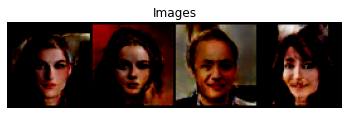

Epoch no - 391
Discriminator Loss : 4.125688 	 Generator_loss : 121.711678
Accuracy on Real Data : 0.925254 	 Accuracy on fake Data : 0.062115
Epoch no - 392
Discriminator Loss : 2.934290 	 Generator_loss : 118.735558
Accuracy on Real Data : 0.927391 	 Accuracy on fake Data : 0.062024
Epoch no - 393
Discriminator Loss : 2.340867 	 Generator_loss : 114.864212
Accuracy on Real Data : 0.948890 	 Accuracy on fake Data : 0.016471
Epoch no - 394
Discriminator Loss : 1.726438 	 Generator_loss : 114.325752
Accuracy on Real Data : 0.973304 	 Accuracy on fake Data : 0.038919
Epoch no - 395
Discriminator Loss : 1.643610 	 Generator_loss : 118.234581
Accuracy on Real Data : 0.971335 	 Accuracy on fake Data : 0.027416
Epoch no - 396
Discriminator Loss : 1.534936 	 Generator_loss : 115.598129
Accuracy on Real Data : 0.965078 	 Accuracy on fake Data : 0.033071
Epoch no - 397
Discriminator Loss : 1.206396 	 Generator_loss : 116.850937
Accuracy on Real Data : 0.982451 	 Accuracy on fake Data : 0.022811

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 400
Discriminator Loss : 0.904112 	 Generator_loss : 120.023560
Accuracy on Real Data : 0.976688 	 Accuracy on fake Data : 0.010301


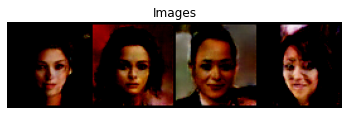

Epoch no - 401
Discriminator Loss : 0.882078 	 Generator_loss : 119.981094
Accuracy on Real Data : 0.986018 	 Accuracy on fake Data : 0.011642
Epoch no - 402
Discriminator Loss : 1.008755 	 Generator_loss : 120.771957
Accuracy on Real Data : 0.983785 	 Accuracy on fake Data : 0.019187
Epoch no - 403
Discriminator Loss : 0.701797 	 Generator_loss : 125.420044
Accuracy on Real Data : 0.986564 	 Accuracy on fake Data : 0.026352
Epoch no - 404
Discriminator Loss : 0.678763 	 Generator_loss : 125.161346
Accuracy on Real Data : 0.983793 	 Accuracy on fake Data : 0.015537
Epoch no - 405
Discriminator Loss : 0.677699 	 Generator_loss : 123.997810
Accuracy on Real Data : 0.959735 	 Accuracy on fake Data : 0.011300
Epoch no - 406
Discriminator Loss : 13.094281 	 Generator_loss : 132.681961
Accuracy on Real Data : 0.947081 	 Accuracy on fake Data : 0.705189
Epoch no - 407
Discriminator Loss : 44.912384 	 Generator_loss : 33.621910
Accuracy on Real Data : 0.699254 	 Accuracy on fake Data : 0.49016

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 410
Discriminator Loss : 16.181213 	 Generator_loss : 144.616226
Accuracy on Real Data : 0.742470 	 Accuracy on fake Data : 0.049799


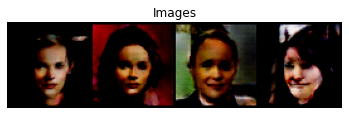

Epoch no - 411
Discriminator Loss : 6.065762 	 Generator_loss : 135.159851
Accuracy on Real Data : 0.912917 	 Accuracy on fake Data : 0.061876
Epoch no - 412
Discriminator Loss : 3.164232 	 Generator_loss : 130.156250
Accuracy on Real Data : 0.916279 	 Accuracy on fake Data : 0.032247
Epoch no - 413
Discriminator Loss : 2.070037 	 Generator_loss : 125.262779
Accuracy on Real Data : 0.967374 	 Accuracy on fake Data : 0.037037
Epoch no - 414
Discriminator Loss : 1.514533 	 Generator_loss : 119.164803
Accuracy on Real Data : 0.977745 	 Accuracy on fake Data : 0.022503
Epoch no - 415
Discriminator Loss : 1.147412 	 Generator_loss : 117.840309
Accuracy on Real Data : 0.975816 	 Accuracy on fake Data : 0.011676
Epoch no - 416
Discriminator Loss : 1.084520 	 Generator_loss : 115.969971
Accuracy on Real Data : 0.962068 	 Accuracy on fake Data : 0.020463
Epoch no - 417
Discriminator Loss : 0.953344 	 Generator_loss : 118.652443
Accuracy on Real Data : 0.964527 	 Accuracy on fake Data : 0.028481

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 420
Discriminator Loss : 0.752989 	 Generator_loss : 122.243935
Accuracy on Real Data : 0.983343 	 Accuracy on fake Data : 0.009358


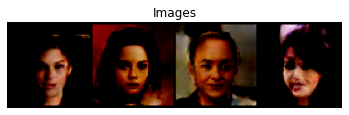

Epoch no - 421
Discriminator Loss : 0.652586 	 Generator_loss : 125.555092
Accuracy on Real Data : 0.967467 	 Accuracy on fake Data : 0.010851
Epoch no - 422
Discriminator Loss : 0.669189 	 Generator_loss : 126.379143
Accuracy on Real Data : 0.980201 	 Accuracy on fake Data : 0.010363
Epoch no - 423
Discriminator Loss : 0.595287 	 Generator_loss : 125.113853
Accuracy on Real Data : 0.993642 	 Accuracy on fake Data : 0.014450
Epoch no - 424
Discriminator Loss : 0.570054 	 Generator_loss : 125.875603
Accuracy on Real Data : 0.982341 	 Accuracy on fake Data : 0.013764
Epoch no - 425
Discriminator Loss : 0.567797 	 Generator_loss : 126.698647
Accuracy on Real Data : 0.990260 	 Accuracy on fake Data : 0.011160
Epoch no - 426
Discriminator Loss : 0.500016 	 Generator_loss : 126.638931
Accuracy on Real Data : 0.992007 	 Accuracy on fake Data : 0.009166
Epoch no - 427
Discriminator Loss : 0.500304 	 Generator_loss : 129.982086
Accuracy on Real Data : 0.993939 	 Accuracy on fake Data : 0.011112

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 430
Discriminator Loss : 0.428492 	 Generator_loss : 133.449371
Accuracy on Real Data : 0.990493 	 Accuracy on fake Data : 0.007800


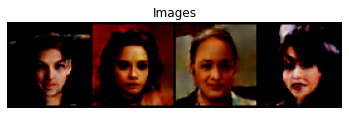

Epoch no - 431
Discriminator Loss : 0.382571 	 Generator_loss : 135.883453
Accuracy on Real Data : 0.993282 	 Accuracy on fake Data : 0.007672
Epoch no - 432
Discriminator Loss : 0.410865 	 Generator_loss : 135.698883
Accuracy on Real Data : 0.992664 	 Accuracy on fake Data : 0.010347
Epoch no - 433
Discriminator Loss : 0.347637 	 Generator_loss : 136.552872
Accuracy on Real Data : 0.996086 	 Accuracy on fake Data : 0.009928
Epoch no - 434
Discriminator Loss : 0.401163 	 Generator_loss : 138.093475
Accuracy on Real Data : 0.986339 	 Accuracy on fake Data : 0.008021
Epoch no - 435
Discriminator Loss : 0.352339 	 Generator_loss : 136.764313
Accuracy on Real Data : 0.985376 	 Accuracy on fake Data : 0.004488
Epoch no - 436
Discriminator Loss : 0.338359 	 Generator_loss : 137.429382
Accuracy on Real Data : 0.996339 	 Accuracy on fake Data : 0.006252
Epoch no - 437
Discriminator Loss : 0.341603 	 Generator_loss : 138.523804
Accuracy on Real Data : 0.981522 	 Accuracy on fake Data : 0.005590

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 440
Discriminator Loss : 0.297681 	 Generator_loss : 141.447800
Accuracy on Real Data : 0.995823 	 Accuracy on fake Data : 0.012445


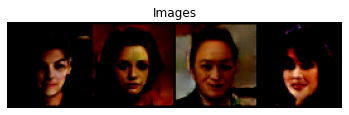

Epoch no - 441
Discriminator Loss : 0.297496 	 Generator_loss : 144.169281
Accuracy on Real Data : 0.994486 	 Accuracy on fake Data : 0.003453
Epoch no - 442
Discriminator Loss : 0.306168 	 Generator_loss : 142.988419
Accuracy on Real Data : 0.995225 	 Accuracy on fake Data : 0.004737
Epoch no - 443
Discriminator Loss : 0.314989 	 Generator_loss : 144.730560
Accuracy on Real Data : 0.991122 	 Accuracy on fake Data : 0.009148
Epoch no - 444
Discriminator Loss : 0.271325 	 Generator_loss : 145.933960
Accuracy on Real Data : 0.993706 	 Accuracy on fake Data : 0.005002
Epoch no - 445
Discriminator Loss : 0.246792 	 Generator_loss : 145.342148
Accuracy on Real Data : 0.993909 	 Accuracy on fake Data : 0.005495
Epoch no - 446
Discriminator Loss : 0.282492 	 Generator_loss : 144.274979
Accuracy on Real Data : 0.996675 	 Accuracy on fake Data : 0.006369
Epoch no - 447
Discriminator Loss : 0.299681 	 Generator_loss : 147.751328
Accuracy on Real Data : 0.989240 	 Accuracy on fake Data : 0.008471

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch no - 450
Discriminator Loss : 0.245282 	 Generator_loss : 149.909149
Accuracy on Real Data : 0.997617 	 Accuracy on fake Data : 0.006705


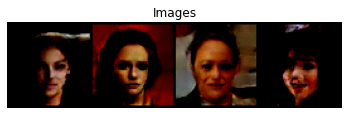

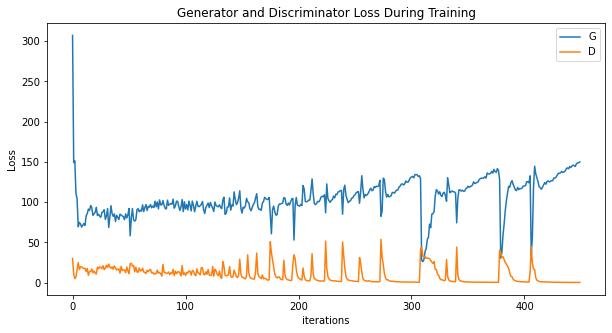

In [ ]:
fit()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


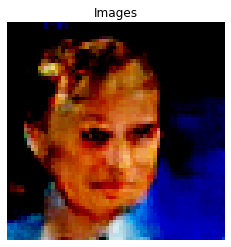

In [ ]:
with torch.no_grad():
  generated_data = generator(noise(1).detach())
  imshow(torchvision.utils.make_grid(vectors_to_images(generated_data)))
  

In [ ]:
'''fit()
with torch.no_grad():
  generated_data = generator(noise(1).detach())
  imshow(torchvision.utils.make_grid(vectors_to_images(generated_data)))'''

'fit()\nwith torch.no_grad():\n  generated_data = generator(noise(1).detach())\n  imshow(torchvision.utils.make_grid(vectors_to_images(generated_data)))'